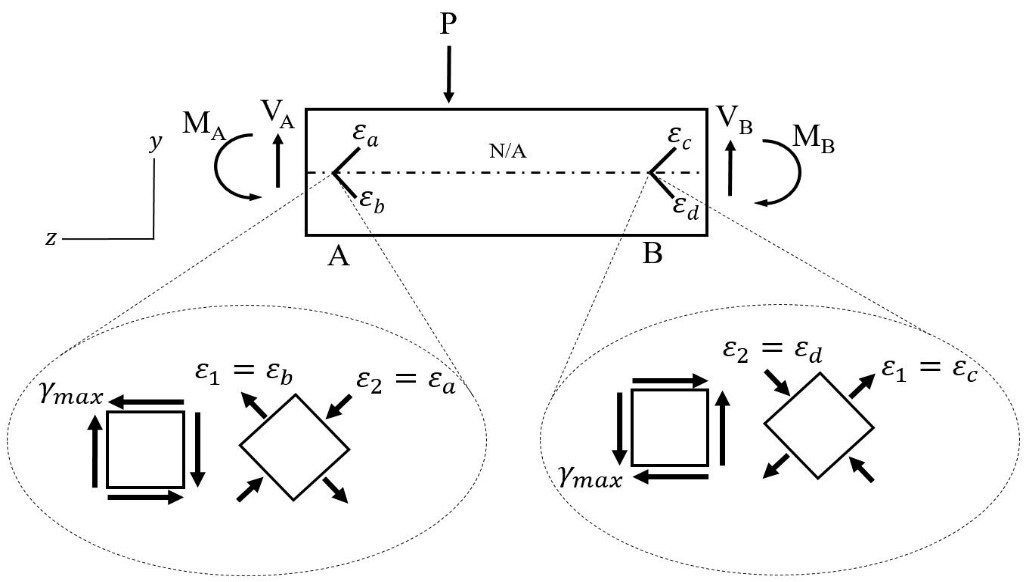

In [3]:
from IPython.display import Image

PATH = "E:\\Dropbox\\Vert_Lat_Load_Estimates\\"
Image(filename = PATH + "OrientationAndStrainState.jpg", width=100, height=100)

# GEOS 505 Research Computing in Earth System Science 
# Final Project: Dataset Overview
***

### D. Kody Johnson                                  
### November 19, 2018
---

## Introduction & Background

Building on the problem statement previously submitted (see Problem_Statement.ipynb), this notebook will explore the generation of training data using the FEM software ABAQUS in conjunction with a python script. To generate all required training data, a parametric study must first be completed in ABAQUS using a python script. However, as the ABAQUS/Python interface requires a significant level of research prior to being able to successfully conduct a parametric study (using a script), the data generation outlined here will be for a single row of a larger (35 line) table. This will show the procedure that the python script will use to convert the output from all 35 model simulations into the required training data consisting of vertical load, lateral load, and the corresponding eight (8) strain gauge measurements.

The basic configuration of strain gauges on the rail as well as the theoretical 2-D strain state is shown in Figure 1. Note that only one side of the rail is shown in Figure 1. In practice, a total of eight (8) strain gauges are used, four (4) on each face of the rail web. 



![title](.\OrientationAndStrainState.jpg)
### <div style="text-align: center"> FIGURE 1  Strain Gauge Orientation and Rail Web Strain State </div> 

The magnitude of P is proportional to the change in the maximum shear strain between points A and B according to the following relationships:<br><br>


$$\gamma_{max}=\epsilon_1-\epsilon_2$$<br>
$$V = \frac{\gamma EIt}{2Q(1+v)}$$<br>
$$P = V_A - V_B = \frac{\gamma EIt}{2Q(1+v)}(\gamma_A - \gamma_B)=\frac{EIt}{2Q(1+v)}[(\epsilon_1-\epsilon_2)_A + (\epsilon_1-\epsilon_2)_B]$$<br>   	 	     	       
               		
where 
	$$V= \textrm{vertical shear force}$$
	$$\gamma=\textrm{maximum shear strain}$$
	$$E= \textrm{modulus of elasticity}$$
	$$I = \textrm{moment of inertia of the rail section}$$
	$$t = \textrm{web thickness}$$
	$$Q= \textrm{statical moment of area of the rail section}$$
	$$v= \textrm{Poisson’s ratio}$$
	$$\epsilon = \textrm{principal strain}$$


Below, is a figure showing the FEM model that will be used in the simulations. This model is of a 132RE rail section one (1) meter in length with a four (4) mm square element at location A and location B respectively (on both the left and right sides). The nodes of this element will be used to simulate strain gauge placement at the nuetral axis of the rail. By calculating the change in length of the lines defined by the diagonals of these elements (gauge length of 5.66 mm), the principal strains at location A and B can be determined and resolved to get the shear strains and ultimately the magnitude of the applied vertical load. 

![title](.\AREMA132RE.jpg)
### <div style="text-align: center"> FIGURE 2   FEM Model of AREMA 132RE Rail Section </div> 


## Workflow
When running this simulation in ABAQUS, the displacements *(U)* of the nodes that define the 'virtual' strain gauges must be output to a data file for postprocessing. The reason for this step is due to the fact that nodal displacements are not output to the database that ABAQUS uses for simulation results with adequate precision to accurately calculate the small changes in strain required for the analysis. Once the ABAQUS/python interface is better understood, it may be possible to do this with the parametric study script. For this notebook however, I will instruct ABAQUS to output these quantities to a data file by modifying the the input text file ABAQUS uses to define and run an analysis, by adding the additional command *NODEPRINT* followed by the desired variable _U_. The script I will develop in subsequent submittals must open all simulation input files prior to running the simulation and insert this text. An example of this modification is provided below (*note: the code below is not executable in python*):

In [ ]:
*Heading
** Job name: 0_50 Model name: 0_50
** Generated by: Abaqus/CAE 2016
*Preprint, echo=NO, model=NO, history=NO, contact=NO
**
** PARTS
**
*Part, name=Rail
*End Part
**  
**
** ASSEMBLY
**
*Assembly, name=Assembly
**  
*Instance, name=Rail-1, part=Rail
*Node
      1, 0.00805894751,  0.189756677,  0.751999974
      2, -0.00860980246,  0.189756677,  0.751999974
      3, -0.00860980246,  0.189756677,           1.
      4, 0.00805894751,  0.189756677,           1...
 ...
 #(here I have removed all nodal and element definitions for brevity)
 ...
*Boundary
_PickedSet508, 2, 2
_PickedSet508, 3, 3
** Name: BC-2 Type: Displacement/Rotation
*Boundary
_PickedSet509, 2, 2
** Name: BC-3 Type: Displacement/Rotation
*Boundary
_PickedSet510, 1, 1
** ----------------------------------------------------------------
** 
** STEP: Step-1
** 
*Step, name=Step-1, nlgeom=NO
*Static, stabilize, allsdtol=0.05, continue=YES
0.1, 1., 1e-09, 1.
#The following text must be inserted here in the input file for each simulation--------------------------------------
*NODEPRINT, NSET=nGauge
U
#End of modification to input file-----------------------------------------------------------------------------------
** 
** LOADS
** 
** Name: Load-1   Type: Concentrated force
*Cload
_PickedSet511, 2, -1e-19
** Name: Load-2   Type: Pressure
*Dsload
Surf-1, P, 1e-19
** Name: Load-3   Type: Pressure
*Dsload
Surf-2, P, 1e-19
** Name: Load-4   Type: Concentrated force
*Cload
_PickedSet512, 1, -50000.
** 
** OUTPUT REQUESTS
** 
*Restart, write, frequency=0
** 
** FIELD OUTPUT: F-Output-1
** 
*Output, field
*Node Output, exterior
U, 
*Element Output, exterior, directions=YES
E, S
** 
** HISTORY OUTPUT: H-Output-1
** 
*Output, history
*Energy Output
ALLAE, 
*End Step      

With the above modification, ABAQUS now appends the output data file (.dat) with the displacement variable *(U)* for all nodes in the node set *nGauge*. The input file must be executed from the ABAQUS command line interface as these modifications are overwritten when using the ABAQUS CAE GUI. Furthermore, due the the required precision, the output must be set to _full_ by using the _output__precision_ keyword. An example of this output is provided below: 

In [ ]:
NODE FOOT-  U1             U2             U3           
            NOTE
  
         5     -1.6373939E-03 -3.7431409E-04 -6.7634341E-05 
         8     -1.6373925E-03 -1.9042103E-04 -1.0286486E-04 
        13     -1.6009827E-03 -3.8108098E-04 -1.0459626E-04 
        14     -1.6456399E-03 -3.7809458E-04 -6.7767696E-05 
        15     -1.6456374E-03 -1.9303484E-04 -1.0267609E-04 
        16     -1.6009799E-03 -1.9353319E-04 -6.3944213E-05 
        19     -1.5913989E-03 -3.7737118E-04 -1.0479153E-04 
        20     -1.5913971E-03 -1.9090487E-04 -6.3695374E-05 
        37     -1.5576357E-03 -1.9282635E-04 -6.6217748E-05 
        38     -1.5576042E-03 -3.8183178E-04 -1.0657467E-04 
        39     -1.5482780E-03 -3.7809332E-04 -1.0679831E-04 
        40     -1.5483100E-03 -1.9022777E-04 -6.5994159E-05 
        45     -1.6028673E-03 -1.9244582E-04 -1.0027554E-04 
        46     -1.6028356E-03 -3.7872952E-04 -6.5860383E-05 
        49     -1.5948992E-03 -1.8986559E-04 -1.0043637E-04 
        50     -1.5948671E-03 -3.7491680E-04 -6.5701170E-05 

After running the analysis for the file '100_0.inp', in which the load combination is 100 kN vertical load and 0 kN lateral load, the following code will open the output data file ('100_50.dat') and read the nodal displacement data for all nodes correspoinding to 'virtual' strain gauges (nodes defined by the set nGauge). The data is then converted to a numpy array (Note: there are 3/4 of a million lines in the output data file making this task nearly impossible without a script):

In [1]:
import numpy as np
import re

with open('100_0.dat') as f:
    lines = f.readlines()
    pat = re.compile(r"\bINCREMENT     6 SUMMARY\b")
    for i in range(0,len(lines),1):
        if pat.search(lines[i]) != None:
            disp = lines[i+19:i+35]
CD = np.zeros([len(disp),4],dtype=float) #CD Coordinate Displacement 
for i in range(0,len(disp),1):
    CD[i] = np.fromstring(disp[i],dtype=float,sep = " ")
    CD = np.vstack(CD)
CD
   

FileNotFoundError: [Errno 2] No such file or directory: '100_0.dat'

Now that the displacements of all the gauge nodes after load application are read into a numpy array, the original coordinates are needed to calculate the strain for the eight (8) strain gauges. These coordinates are writen to the input file (.inp) by abaqus. They can also be written to the data file (like the displacements were), however the .inp file has a higher coordinate precision then can be obtained from subsequent output. As these coordinates are the same for all simulations, they have been copied from the .inp file into a separate text file 'orig_coords.txt' (Note, the file contains nodes 1 through 50 which are not all strain gauge nodes). The following code reads this file and saves the appropriate coords to a numpy array.   

In [ ]:
import numpy as np

with open('orig_coords.txt') as f:
    lines = f.readlines()
OC = np.zeros([len(lines),4],dtype=float)    #Original Coordinate Array
for i in range(0,len(lines),1):
    OC[i] = np.fromstring(lines[i],dtype=float,sep = ",")
OC = np.vstack(OC)
OC


The arrays OC and CD arrays must now be arranged in an understandable order. For each 'virtual' gauge element, the convention used will be the positive 45 degree diagonal followed by the negative 45 degree diagonal, and starting with the right side at location A then B followed by the left side at A and B. The following code completes this task for the OC (original coordinate) array:


In [ ]:
OP = np.zeros([16,3],dtype=float)    #Original point
for i in range(0,50,1):
    if OC[i,0] == 49.:
        OP[0,:] = OC[i,1:4]
    elif OC[i,0] == 15.:
        OP[1,:] = OC[i,1:4]
    elif OC[i,0] == 8.:
        OP[2,:] = OC[i,1:4]
    elif OC[i,0] == 45.:
        OP[3,:] = OC[i,1:4]
    elif OC[i,0] == 37.:
        OP[4,:] = OC[i,1:4]
    elif OC[i,0] == 20.:
        OP[5,:] = OC[i,1:4]
    elif OC[i,0] == 16.:
        OP[6,:] = OC[i,1:4] 
    elif OC[i,0] == 40.:
        OP[7,:] = OC[i,1:4]
    elif OC[i,0] == 50.:
        OP[8,:] = OC[i,1:4]
    elif OC[i,0] == 14.:
        OP[9,:] = OC[i,1:4]
    elif OC[i,0] == 5.:
        OP[10,:] = OC[i,1:4]
    elif OC[i,0] == 46.:
        OP[11,:] = OC[i,1:4]
    elif OC[i,0] == 38.:
        OP[12,:] = OC[i,1:4]
    elif OC[i,0] == 19.:
        OP[13,:] = OC[i,1:4]
    elif OC[i,0] == 13.:
        OP[14,:] = OC[i,1:4]
    elif OC[i,0] == 39.:
        OP[15,:] = OC[i,1:4]      
print(OP)

In [ ]:
U = np.zeros([16,3],dtype=float)    #nodal displacement
for i in range(0,16,1):
    if CD[i,0] == 49.:
        U[0,:] = CD[i,1:4]
    elif CD[i,0] == 15.:
        U[1,:] = CD[i,1:4]
    elif CD[i,0] == 8.:
        U[2,:] = CD[i,1:4]
    elif CD[i,0] == 45.:
        U[3,:] = CD[i,1:4]
    elif CD[i,0] == 37.:
        U[4,:] = CD[i,1:4]
    elif CD[i,0] == 20.:
        U[5,:] = CD[i,1:4]
    elif CD[i,0] == 16.:
        U[6,:] = CD[i,1:4] 
    elif CD[i,0] == 40.:
        U[7,:] = CD[i,1:4]
    elif CD[i,0] == 50.:
        U[8,:] = CD[i,1:4]
    elif CD[i,0] == 14.:
        U[9,:] = CD[i,1:4]
    elif CD[i,0] == 5.:
        U[10,:] = CD[i,1:4]
    elif CD[i,0] == 46.:
        U[11,:] = CD[i,1:4]
    elif CD[i,0] == 38.:
        U[12,:] = CD[i,1:4]
    elif CD[i,0] == 19.:
        U[13,:] = CD[i,1:4]
    elif CD[i,0] == 13.:
        U[14,:] = CD[i,1:4]
    elif CD[i,0] == 39.:
        U[15,:] = CD[i,1:4]      
print(U)

With the original nodal coordinates and the displacement of each node properly initialized and organized in a meaningful way, it is now possible to calculate the strains that a strain gauge would experience under the given loading conditions. This step is carried out in the following code:  

In [ ]:
DP = np.zeros([16,3],dtype=float)   #Deformed point
DP = OP + U                          

OL = np.zeros([8,1],dtype=float)    #Original line
DL = np.zeros([8,1],dtype=float)    #Deformed line

for i in range(0,8,1):
    OL[i,0] = np.linalg.norm(OP[2*i+1,:]-OP[2*i,:])
    DL[i,0] = np.linalg.norm(DP[2*i+1,:]-DP[2*i,:])
    
ST = (DL - OL)/OL    #Definition of infitesimal strain.
ST = np.transpose(ST)
ST

These eight values form eight (8) columns of a ten (10) column row vector. The other two (2) columns are the vertical and lateral load applied to generate the strain values. Vertical and lateral load values will be read from the file name and concatenated to the row vector of strain values thus forming one row of the training data array. As the file name of each .dat file contains the applied vertical and lateral load (i.e. '100_50.dat'), the python os.walk method can be invoked to read all the .dat files and generate a list of file names. Each element of the list can then be split into a vertical load list and a lateral load list. Finally, the two lists can be converted into numpy arrays and concatenated onto the ST row vector shown above. Again, this will provide one row of a larger array with a row for each simulation. As an example, the following code will perform this task on a manually entered file name:

In [ ]:
import re
import numpy as np

file = '100_50.txt'
file = re.split('_|\.',file)
vert = file[0]
lat = file[1]
load = np.array([[float(vert),float(lat)]])
load.shape
tr_data = np.concatenate([load,ST],axis=1)
tr_data

As a check to ensure that the preceding operations were carried out correctly, the following code checks to see if the strain gauge values can be used to correctly calculate the applied load P (100,000 N) according to the theory presented above:

In [ ]:
ST = np.transpose(ST)

ea = ST[0]
eb = ST[1]
ec = ST[2]
ed = ST[3]
eap = ST[4]
ebp = ST[5]
ecp = ST[6]
edp = ST[7]

e1 = (eb + ebp)/2 - (ea + eap)/2
e2 = (ec + ecp)/2 - (ed + edp)/2

delG = e1 + e2

E = 2.07E+11
I = 3.661E-05
t = 0.0173795
Q = 0.000258773
v = 0.30

P = E*I*t/(2*Q*(1+v))*delG
P

This value is very close to the applied load, well within any numerical error introduced in the finite element method. The percentage difference between the applied load and the calculated load is:

In [ ]:
delP = (P-100000)/100000*100
delP

## Conclusion
Using this workflow, virtual strain gauge readings were calcuated from the nodal deformations of an ABAQUS FE model. These strain gauge readings were then used to calculate the applied load based on the differential shear principal presented above. The minimal error in the calculation is a verification that the steps outlined in the workflow were successfully performed. In the next submittal, a python script will be written to conduct a parametric study in ABAQUS which will generate a series of output data files (.dat). These files will then be used with a slightly modified version of the workflow presented here. Using os.walk, a list of these files will be created which will then be opened sequentially to create additional rows to the training data array (tr_data) as shown in previously. Subsequently, this training data array will be used in a multivariate multiple linear regression to find a mapping funtion between eight (8) strain gauge measurements and the applied vertical and lateral load. 